In [1]:
import os

class Constants:
    ## PATHs ##
    DATASET_ROOT = './ip102_v1.1/'
    IMG_ROOT = os.path.join(DATASET_ROOT, "images")
    TRAIN_PATH = os.path.join(DATASET_ROOT, "train.txt")
    VAL_PATH = os.path.join(DATASET_ROOT, "val.txt")
    TEST_PATH = os.path.join(DATASET_ROOT, "test.txt")
    ID_LABEL_PATH = os.path.join('./', "classes.txt")

In [2]:
import numpy as np
import os
from torch.utils.data import Dataset
from constants import Constants
from PIL import Image

## Get Path of .txt file path,label like: 75219.jpg 101
## returns array of tuples in (path, label)
def load_split_file(file_path):
    with open(file_path,'r') as f:
        samples = np.array(
            [(path,int(label)) for path, label in (line.strip().split() for line in f)],
            dtype= object
        )
    return samples


def load_labels(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    labels = []
    ids = []
    for line in lines:
        id_str, label = line.strip().split(maxsplit=1)
        id = int(id_str)
        ids.append(id)
        labels.append(label)
    return ids, labels

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self,image2class_path,transform=None):
        
        self.data_list = load_split_file(image2class_path)
        self.root_dir = Constants.IMG_ROOT    
        self.transform = transform

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        image_path= os.path.join(self.root_dir,path)
        image= Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
from read_data import CustomImageDataset
from constants import Constants
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(Constants.TRAIN_PATH, transform=transform)
val_dataset = CustomImageDataset(Constants.VAL_PATH, transform=transform)
test_dataset = CustomImageDataset(Constants.TEST_PATH, transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

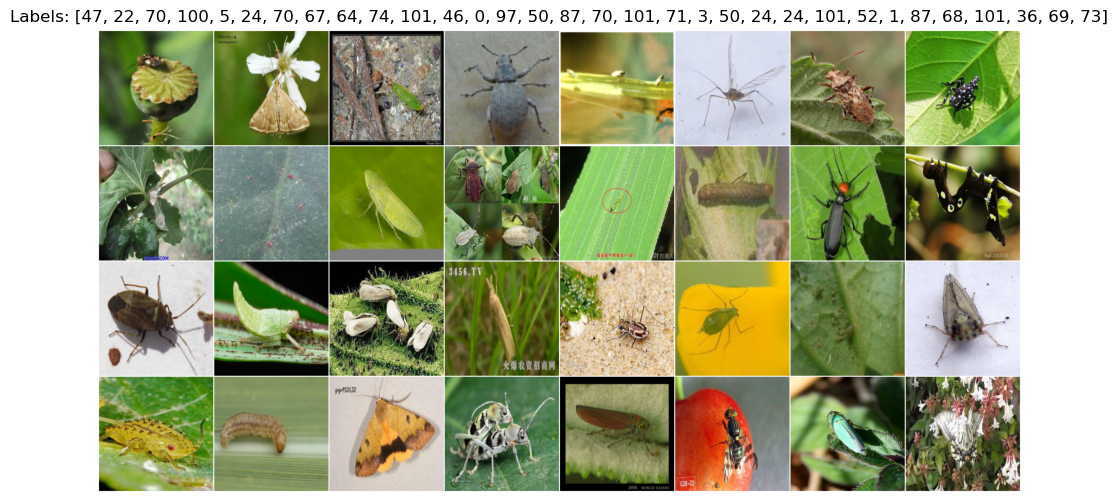

In [9]:
images, labels = next(iter(train_loader))

# Make a grid of images
grid = make_grid(images, nrow=8, normalize=True, pad_value=1)

# Convert to numpy for plotting
npimg = grid.permute(1, 2, 0).numpy()

# Plot the grid
plt.figure(figsize=(12, 6))
plt.imshow(npimg)
plt.title(f"Labels: {labels.tolist()}")
plt.axis("off")
plt.show()

In [10]:
ids, labels = load_labels(Constants.ID_LABEL_PATH)

In [ ]:
import torch
from transformers import Blip2Processor, Blip2ForImageTextRetrieval
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Salesforce/blip2-flan-t5-xl"
model = Blip2ForImageTextRetrieval.from_pretrained(model_name).to(device)
processor = Blip2Processor.from_pretrained(model_name)

model.eval() 

# 3. one-time embedding for prompt
with torch.no_grad():
    class_inputs = processor(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)
    class_embeddings = model.get_text_features(**class_inputs)  # [num_classes x dim]
    class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)  # normalize

# 4. validation loader
correct = 0
total = 0

for batch in tqdm(val_loader):
    images, labels = batch
    images = list(image.convert("RGB") for image in images)
    labels = labels.to(device)

    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt").to(device)
        image_embeddings = model.get_image_features(**inputs)  # [B x dim]
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)  # normalize

        # similarity: [B x num_classes]
        sims = torch.matmul(image_embeddings, class_embeddings.T)
        preds = torch.argmax(sims, dim=1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)

acc = correct / total
print(f"✅ Validation Accuracy: {acc:.4f}")